<Axes: >

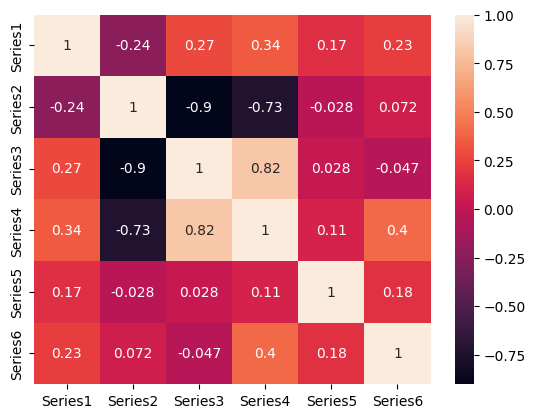

In [1]:
import pandas as pd
import seaborn as sbn

data = pd.read_csv("data.csv", parse_dates=["Date"], index_col=0)

sbn.heatmap(data.corr(), annot=True)

In [2]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error


def fit_regressor(data: pd.DataFrame, column: str) -> xgb.XGBRegressor:
    print(f"\tTraining regressor for column - {column}")
    
    data_nonull = data.dropna()

    train, test = train_test_split(data_nonull, test_size=0.1)
    train_X, train_y = train[[c for c in train.columns if c != column]], train[column]
    test_X, test_y = test[[c for c in train.columns if c != column]], test[column]

    regressor = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=24
    )
    regressor.fit(train_X, train_y)
    y_pred = regressor.predict(test_X)

    print(f"\tRegressor metrics for column {column}: ")
    print("\t\tR2 score: ", r2_score(test_y, y_pred))
    print("\t\tMAE: ", mean_absolute_error(test_y, y_pred))
    print("\t\tRMSE: ", root_mean_squared_error(test_y, y_pred))
    
    return regressor


def fill_nan_with_regression(data: pd.DataFrame, regressor: xgb.XGBRegressor, column: str) -> None:
    
    features = [c for c in data.columns if c != column]
    data_for_regression = data.loc[
        data[column].isna() & data[features].notna().all(axis=1), 
        :
    ]
    data.loc[
        data[column].isna() & data[features].notna().all(axis=1), column
    ] = regressor.predict(data_for_regression[features])
    

def fill_nan_values(data: pd.DataFrame, iterations: int = 1) -> None:
    
    for iteration in range(iterations):
        
        print(f"Working on iteration {iteration}...")
        
        print(f"\tNumber of NaN values before filling: {len(data[data.isna().any(axis=1)])}")
        
        for column in data.columns:
            
            print(f"\tFilling NaN in column: {column}")
            
            regressor = fit_regressor(data, column)
            
            fill_nan_with_regression(data, regressor, column)
            
        print(f"\tNumber of NaN values after filling: {len(data[data.isna().any(axis=1)])}")
        
    print(f"Filling NaN's has ended. Final number of NaN's is: {len(data[data.isna().any(axis=1)])}")

In [3]:
data = pd.read_csv("data.csv", parse_dates=["Date"], index_col=0)

# Filling most of NaN values in-place using XGBoost   
fill_nan_values(data, iterations=1)

# Filling the rest of NaN's values using cubic interpolation
non_null_data = data.interpolate("cubic")

# Saving the results
non_null_data.to_csv("data_clean.csv")

Working on iteration 0...
	Number of NaN values before filling: 243056
	Filling NaN in column: Series1
	Training regressor for column - Series1
	Regressor metrics for column Series1: 
		R2 score:  0.8034379383363571
		MAE:  0.37364001261532004
		RMSE:  0.6392459718409869
	Filling NaN in column: Series2
	Training regressor for column - Series2
	Regressor metrics for column Series2: 
		R2 score:  0.9281735169006782
		MAE:  0.2302565852591823
		RMSE:  0.3902127719139973
	Filling NaN in column: Series3
	Training regressor for column - Series3
	Regressor metrics for column Series3: 
		R2 score:  0.9806254598476438
		MAE:  0.11294462981991885
		RMSE:  0.2054850202455464
	Filling NaN in column: Series4
	Training regressor for column - Series4
	Regressor metrics for column Series4: 
		R2 score:  0.9741594118120182
		MAE:  0.12979392939323547
		RMSE:  0.23643843909154258
	Filling NaN in column: Series5
	Training regressor for column - Series5
	Regressor metrics for column Series5: 
		R2 score: 

In [2]:
import numpy as np
from scipy import stats

# Calculate z-scores
z_scores = np.abs(stats.zscore(data, nan_policy='omit'))

# Define a threshold for what we consider an outlier
threshold = 3  # typical value: 3 standard deviations

# Replace outliers with NaN
df_no_outliers = data.mask(z_scores > threshold)


data = df_no_outliers.interpolate(method="time")

In [3]:
data.to_csv("data_clean.csv")